In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import datetime
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import keras
import pickle

Using TensorFlow backend.


In [ ]:
#Getting the dataset
df = pd.read_csv('Solar.csv')
df.head(6)

,Site,Latitude,Longitude,Date,Air Temperature (C°),Wind Speed at 3m (m/s),DHI (Wh/m2),DHI Uncertainty (Wh/m2),DNI (Wh/m2),DNI Uncertainty (Wh/m2),GHI (Wh/m2),GHI Uncertainty (Wh/m2),Relative Humidity (%),Relative Humidity Uncertainty (%),Barometric Pressure (mB (hPa equiv)),Barometric Pressure Uncertainty (mB (hPa equiv)),power_out_kwh,power_out_farm_kwh
0,Duba - TVTC,27.34103,35.72295,2013-08-01,31.7,2.1,1450.2,117.8,8478.8,561.9,7454.3,468.4,56.1,3.0,1001.3,5.0,210.081,1.302504e+07
1,Duba - TVTC,27.34103,35.72295,2013-09-01,31.2,2.5,1500.8,227.2,7584.2,1056.5,6605.2,745.2,50.6,3.0,1004.2,5.0,297.402,1.843893e+07
2,Duba - TVTC,27.34103,35.72295,2013-10-01,27.6,2.2,1076.9,189.7,7772.4,1076.0,5662.9,719.9,49.1,3.0,1007.8,5.0,315.090,1.953558e+07
3,Duba - TVTC,27.34103,35.72295,2013-11-01,25.8,2.1,1192.5,216.3,6161.1,776.9,4447.3,562.9,43.0,3.0,1009.3,5.0,363.833,2.255767e+07
4,Duba - TVTC,27.34103,35.72295,2013-12-01,21.1,2.6,1204.7,124.8,5047.5,727.4,3611.0,411.2,39.2,3.0,1013.8,5.1,447.408,2.773927e+07
5,Duba - TVTC,27.34103,35.72295,2014-01-01,21.0,2.3,1040.9,108.0,6519.4,483.2,4288.5,278.0,42.2,3.0,1012.9,5.1,402.770,2.497175e+07


In [ ]:
#We don't need those columns, so we remove it from the dataset and store the resulting dataset onto df1.
df1 = df.drop(['Site','Latitude','Longitude','Date','power_out_farm_kwh'],axis=1)

In [ ]:
df1.head()

,Air Temperature (C°),Wind Speed at 3m (m/s),DHI (Wh/m2),DHI Uncertainty (Wh/m2),DNI (Wh/m2),DNI Uncertainty (Wh/m2),GHI (Wh/m2),GHI Uncertainty (Wh/m2),Relative Humidity (%),Relative Humidity Uncertainty (%),Barometric Pressure (mB (hPa equiv)),Barometric Pressure Uncertainty (mB (hPa equiv)),power_out_kwh
0,31.7,2.1,1450.2,117.8,8478.8,561.9,7454.3,468.4,56.1,3.0,1001.3,5.0,210.081
1,31.2,2.5,1500.8,227.2,7584.2,1056.5,6605.2,745.2,50.6,3.0,1004.2,5.0,297.402
2,27.6,2.2,1076.9,189.7,7772.4,1076.0,5662.9,719.9,49.1,3.0,1007.8,5.0,315.090
3,25.8,2.1,1192.5,216.3,6161.1,776.9,4447.3,562.9,43.0,3.0,1009.3,5.0,363.833
4,21.1,2.6,1204.7,124.8,5047.5,727.4,3611.0,411.2,39.2,3.0,1013.8,5.1,447.408


In [ ]:
#replacing all the -np.inf with 0
df1.replace([-np.inf,np.inf],0,inplace=True)

In [ ]:
#Taking a look at those rows with power_out_kwh<=0
df1[df1.iloc[:,-1]<=0]

,Air Temperature (C°),Wind Speed at 3m (m/s),DHI (Wh/m2),DHI Uncertainty (Wh/m2),DNI (Wh/m2),DNI Uncertainty (Wh/m2),GHI (Wh/m2),GHI Uncertainty (Wh/m2),Relative Humidity (%),Relative Humidity Uncertainty (%),Barometric Pressure (mB (hPa equiv)),Barometric Pressure Uncertainty (mB (hPa equiv)),power_out_kwh
154,23.1,0.4,2492.4,751.0,6099.6,1840.7,6791.0,1443.9,21.2,2.9,926.3,4.6,-1031.804
155,27.5,0.0,1894.8,652.0,7888.3,1834.3,7630.7,1514.5,17.3,3.0,925.1,4.6,0.000
311,30.4,0.4,2215.3,95.7,6767.4,344.0,7170.1,298.8,68.8,3.0,1002.7,5.0,-1144.188
400,32.5,0.0,2707.0,138.5,4926.1,253.4,6309.4,294.2,56.4,3.0,1004.7,5.0,0.000
402,26.5,0.0,1566.3,256.8,5473.5,543.6,4643.4,458.5,56.0,3.3,1011.7,5.5,0.000
404,26.8,0.0,2414.7,104.6,6962.9,286.4,7540.4,244.7,56.5,3.0,1007.9,5.0,0.000
405,31.5,0.0,3416.5,160.5,5288.5,366.6,7572.4,355.7,44.0,3.0,1005.7,5.0,0.000
406,32.0,0.0,2673.0,233.5,6763.5,550.6,7806.4,583.5,52.8,3.0,1002.9,5.0,0.000
435,30.7,0.1,2196.5,165.7,4822.4,367.0,5409.6,349.0,76.5,3.0,1007.3,5.0,-4562.866
436,27.9,0.4,1549.8,138.1,5461.2,447.4,4725.4,304.8,72.7,3.0,1009.1,5.0,-558.875


In [ ]:
#Taking a look at those rows with power_out_kwh>0
df1[df1.iloc[:,-1]>0]

,Air Temperature (C°),Wind Speed at 3m (m/s),DHI (Wh/m2),DHI Uncertainty (Wh/m2),DNI (Wh/m2),DNI Uncertainty (Wh/m2),GHI (Wh/m2),GHI Uncertainty (Wh/m2),Relative Humidity (%),Relative Humidity Uncertainty (%),Barometric Pressure (mB (hPa equiv)),Barometric Pressure Uncertainty (mB (hPa equiv)),power_out_kwh
0,31.7,2.1,1450.2,117.8,8478.8,561.9,7454.3,468.4,56.1,3.0,1001.3,5.0,210.081
1,31.2,2.5,1500.8,227.2,7584.2,1056.5,6605.2,745.2,50.6,3.0,1004.2,5.0,297.402
2,27.6,2.2,1076.9,189.7,7772.4,1076.0,5662.9,719.9,49.1,3.0,1007.8,5.0,315.090
3,25.8,2.1,1192.5,216.3,6161.1,776.9,4447.3,562.9,43.0,3.0,1009.3,5.0,363.833
4,21.1,2.6,1204.7,124.8,5047.5,727.4,3611.0,411.2,39.2,3.0,1013.8,5.1,447.408
...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,29.4,3.2,2679.4,225.5,5946.1,540.2,7129.6,476.0,46.2,3.0,995.7,5.0,342.158
630,33.3,3.7,3148.5,255.3,5293.3,495.4,7282.0,466.3,39.5,3.0,993.8,5.0,354.517
631,33.9,3.3,3114.1,245.7,5273.3,532.0,7254.0,468.8,46.5,3.0,991.6,5.0,330.901
632,34.7,3.0,2931.9,224.3,5391.5,504.9,7178.2,520.5,44.5,3.0,991.7,5.0,310.016


In [ ]:
#we've removed those rows with power_out_kwh<=0, since we find these to be outliers
df1.drop(df1[df1.iloc[:,-1]<=0].index,axis=0, inplace=True)
df1 = df1.reset_index(drop=True)

In [ ]:
#We see that every column in the df1 has minimum value >0
df1.min() 

Air Temperature (C°)                                   9.700
Wind Speed at 3m (m/s)                                 1.500
DHI (Wh/m2)                                          905.400
DHI Uncertainty (Wh/m2)                               41.100
DNI (Wh/m2)                                         2989.100
DNI Uncertainty (Wh/m2)                              149.000
GHI (Wh/m2)                                         3403.900
GHI Uncertainty (Wh/m2)                              111.000
Relative Humidity (%)                                 12.200
Relative Humidity Uncertainty (%)                      2.800
Barometric Pressure (mB (hPa equiv))                 912.400
Barometric Pressure Uncertainty (mB (hPa equiv))       4.500
power_out_kwh                                        168.938
dtype: float64

In [ ]:
#In this piece of code, we've performed 7 fold cross-validation for evaluating the quality of the neural network..
#However we've stored the val_res = [loss, val_mse, val_mae, val_mape, val_cosine] for each of those 7 evaluations, from which we can judge the performance of our neural network model.
# Note that loss function used for training the neural network is MSE, so the val_mse and validation loss means the same.
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=7,shuffle=True,random_state=5)
kf.get_n_splits(df1.iloc[:,:-1])
ctr = 0
val_res = []

for train_index, test_index in kf.split(df1.iloc[:,:-1]):
  X_train, X_test = df1.iloc[train_index,:-1], df1.iloc[test_index,:-1]
  y_train, y_test = df1.iloc[train_index,-1], df1.iloc[test_index,-1]
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_np = scaler.transform(X_train)
  X_test_np = scaler.transform(X_test)
  model = Sequential()
  model.add(Dense(200, input_dim=12, activation='tanh',kernel_initializer=keras.initializers.glorot_normal(seed=42)))
  #model.add(Dense(100, activation='relu',kernel_initializer='glorot_normal'))
  model.add(Dense(1, activation='relu',kernel_initializer=keras.initializers.glorot_normal(seed=42)))
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae','mape','cosine'])
  history_pow = model.fit(X_train_np, y_train, epochs=550, batch_size=8, shuffle=True,validation_data=(X_test_np,y_test))
  model.save('solar_models_neww'+str(ctr))
  with open('history_solars_neww'+str(ctr),'wb') as file1:
    pickle.dump(history_pow,file1)
  ctr+=1
  print(".....1 done.....")
  val_res.append(model.evaluate(X_test_np,y_test,batch_size=8))

Streaming output truncated to the last 5000 lines.
530/530 [==============================] - 0s 165us/step - loss: 468.0300 - mse: 468.0301 - mae: 2.8413 - mape: 0.9353 - cosine: 0.9943 - val_loss: 3897.4793 - val_mse: 3897.4795 - val_mae: 11.0900 - val_mape: 2.5194 - val_cosine: 0.9886
Epoch 259/550
530/530 [==============================] - 0s 176us/step - loss: 468.2376 - mse: 468.2375 - mae: 2.9293 - mape: 0.9622 - cosine: 0.9943 - val_loss: 3907.9011 - val_mse: 3907.9016 - val_mae: 11.2302 - val_mape: 2.5670 - val_cosine: 0.9886
Epoch 260/550
530/530 [==============================] - 0s 176us/step - loss: 468.8051 - mse: 468.8051 - mae: 3.0134 - mape: 0.9855 - cosine: 0.9943 - val_loss: 3883.5246 - val_mse: 3883.5242 - val_mae: 11.1889 - val_mape: 2.5461 - val_cosine: 0.9886
Epoch 261/550
530/530 [==============================] - 0s 175us/step - loss: 468.1784 - mse: 468.1784 - mae: 2.8631 - mape: 0.9407 - cosine: 0.9943 - val_loss: 3883.4495 - val_mse: 3883.4490 - val_mae: 11.

In [ ]:
#We see here in 5 out of 7 evaluations our neural network has loss(val_mse) less than 5 which is very good, the other 2 evaluations have quite high loss(val_mse), this is not because our neural network is bad, 
#but it might be due to the fact that other 2 evaluations would have required neural networks tuned for them. Nevertheless we see that evaluations #: 6 has the very least val_mse, so we use that model  as the 
#final model for further prediction purposes.

#So the evaluation #6 has following results = [1.0155535448681225,1.0155534744262695, 0.8549442291259766, 0.24021196365356445, 1.0]
#The first 2 values are loss and val_mse which both are exactly same.

val_res

[[2.896675682804558,
  2.8966758251190186,
  0.8719657063484192,
  0.30352362990379333,
  1.0],
 [2.5983646779917597,
  2.59836483001709,
  0.9108744263648987,
  0.24941743910312653,
  1.0],
 [242.79807596856898,
  242.79808044433594,
  3.1914308071136475,
  0.7816957831382751,
  1.0],
 [2.2996288443153556,
  2.299628973007202,
  0.969937264919281,
  0.2867720127105713,
  1.0],
 [2.324052921750329,
  2.3240528106689453,
  0.873473584651947,
  0.23370389640331268,
  1.0],
 [1.0155535448681225,
  1.0155534744262695,
  0.8549442291259766,
  0.24021196365356445,
  1.0],
 [222.57787257365206,
  222.57786560058594,
  2.6134278774261475,
  0.9974903464317322,
  1.0]]

In [ ]:
#Loading solar_models_neww5 and history_solars_neww5  corresponding to evaluation #6
model = keras.models.load_model('solar_prediction_model')
with open('history_solars_neww5','rb') as file1:
  history_pow = pickle.load(file1)

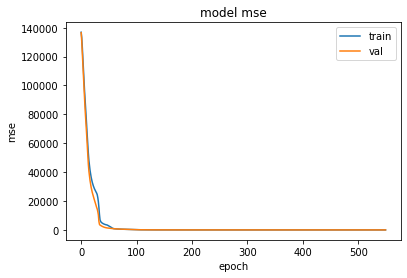

In [ ]:
#MSE plot
plt.plot(history_pow.history['mse'])
plt.plot(history_pow.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

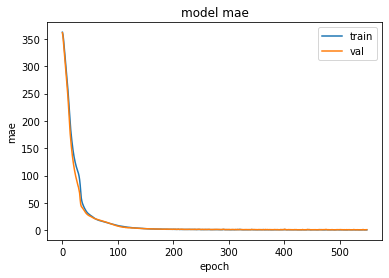

In [ ]:
#MAE plot
plt.plot(history_pow.history['mae'])
plt.plot(history_pow.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

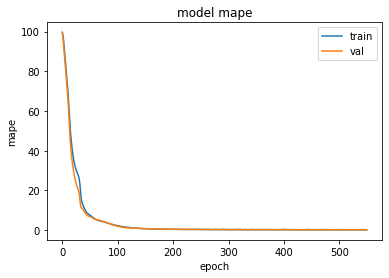

In [ ]:
#MAPE plot
plt.plot(history_pow.history['mape'])
plt.plot(history_pow.history['val_mape'])
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
#Extracting the train and test dataset corresponding to evaluation #6
train_index, test_index = list(kf.split(df1.iloc[:,:-1]))[5]
X_train, X_test = df1.iloc[train_index,:-1], df1.iloc[test_index,:-1]
y_train, y_test = df1.iloc[train_index,-1], df1.iloc[test_index,-1]
scaler = StandardScaler()
scaler.fit(X_train)
X_train_np = scaler.transform(X_train)
X_test_np = scaler.transform(X_test)
model.evaluate(X_test_np,y_test,batch_size=8)

88/88 [==============================] - 0s 113us/step


[1.0155535448681225,
 1.0155534744262695,
 0.8549442291259766,
 0.24021196365356445,
 1.0]

In [ ]:
#final output which compares predicted and actual power_out_kwh
df_pred = df1.iloc[test_index,:].copy()
df_pred['pred_power_out_kwh'] = model.predict(X_test_np).reshape(1,-1)[0]
df_pred

,Air Temperature (C°),Wind Speed at 3m (m/s),DHI (Wh/m2),DHI Uncertainty (Wh/m2),DNI (Wh/m2),DNI Uncertainty (Wh/m2),GHI (Wh/m2),GHI Uncertainty (Wh/m2),Relative Humidity (%),Relative Humidity Uncertainty (%),Barometric Pressure (mB (hPa equiv)),Barometric Pressure Uncertainty (mB (hPa equiv)),power_out_kwh,pred_power_out_kwh
19,24.800000,2.700000,1967.000000,172.200000,6072.60000,510.900000,5973.300000,395.900000,41.800000,3.000000,1009.400000,5.100000,358.025,358.350861
20,25.500000,2.900000,2193.300000,213.300000,7355.40000,558.800000,7474.300000,451.300000,39.400000,3.000000,1009.400000,5.100000,321.346,321.279785
22,30.600000,2.600000,2004.700000,225.900000,8290.30000,576.700000,8090.900000,477.300000,49.200000,3.000000,1004.100000,5.000000,254.887,255.026459
30,22.200000,2.500000,1144.800000,127.100000,7722.40000,524.900000,5492.100000,354.700000,38.300000,3.000000,1013.700000,5.100000,367.621,368.852722
35,32.200000,2.200000,1431.000000,112.000000,8847.10000,590.300000,7826.500000,498.300000,60.600000,3.000000,1000.700000,5.000000,207.777,207.853149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,32.800000,2.800000,2651.500000,253.600000,4528.10000,477.300000,6071.600000,517.300000,69.000000,3.000000,993.400000,4.900000,337.153,337.533722
601,31.100000,2.200000,2000.900000,134.700000,5253.30000,342.000000,5525.200000,343.300000,68.400000,3.000000,996.900000,5.000000,310.058,308.742340
609,27.299051,1.985359,2016.435556,210.948254,6120.16254,584.373016,6101.853724,535.580507,48.528323,3.001741,985.072152,4.933228,268.845,267.858124
614,33.300000,3.700000,3148.500000,255.300000,5293.30000,495.400000,7282.000000,466.300000,39.500000,3.000000,993.800000,5.000000,354.517,355.324188


In [ ]:
df_pred.to_csv('solar_pred.csv')

**Code for Prediction of wind power_out_kwh starts**

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import datetime
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import keras
import pickle


Using TensorFlow backend.


In [ ]:
#Getting  the dataset
df = pd.read_csv('dataset.csv')
df.head(6)

,observation_date,station_id,station_name,station_country,latitude,longitude,elevation,wind_direction_angle,wind_direction_angle_units,wind_type,wind_speed_rate,wind_speed_rate_units,sky_ceiling_height,sky_ceiling_height_units,sky_ceiling_determination,sky_cavok,visibility_distance,visibility_distance_units,visibility_variability,air_temperature,air_temperature_units,air_temperature_dew_point,air_temperature_dew_point_units,atmospheric_sea_level_pressure,atmospheric_sea_level_pressure_units,air_density,power_out_kw
0,1973-01-01 06:00:00,40375099999,TABUK,SA,28.365417,36.618889,777.54,234.51,ANGULAR DEGREES,Calm,0.0,METERS PER SECOND,22000.0,METERS,Statistically:derived,No,12000.0,METERS,Not variable,1.0,DEGREES CELSIUS,3.0,DEGREES CELSIUS,1029.2,HECTOPASCALS,1.304,0.000
1,1973-01-01 09:00:00,40375099999,TABUK,SA,28.365417,36.618889,777.54,90.00,ANGULAR DEGREES,Normal,5.1,METERS PER SECOND,22000.0,METERS,Statistically:derived,No,12000.0,METERS,Not variable,9.0,DEGREES CELSIUS,7.0,DEGREES CELSIUS,1026.9,HECTOPASCALS,1.263,26316.605
2,1973-01-01 12:00:00,40375099999,TABUK,SA,28.365417,36.618889,777.54,40.00,ANGULAR DEGREES,Normal,4.1,METERS PER SECOND,22000.0,METERS,Statistically:derived,No,12000.0,METERS,Not variable,12.0,DEGREES CELSIUS,3.0,DEGREES CELSIUS,1022.0,HECTOPASCALS,1.245,13476.774
3,1973-01-01 15:00:00,40375099999,TABUK,SA,28.365417,36.618889,777.54,60.00,ANGULAR DEGREES,Normal,5.1,METERS PER SECOND,22000.0,METERS,Statistically:derived,No,12000.0,METERS,Not variable,9.0,DEGREES CELSIUS,3.0,DEGREES CELSIUS,1025.7,HECTOPASCALS,1.263,26309.470
4,1973-01-01 18:00:00,40375099999,TABUK,SA,28.365417,36.618889,777.54,80.00,ANGULAR DEGREES,Normal,7.2,METERS PER SECOND,22000.0,METERS,Statistically:derived,No,12000.0,METERS,Not variable,4.0,DEGREES CELSIUS,6.0,DEGREES CELSIUS,1028.9,HECTOPASCALS,1.289,75550.442
5,1973-01-02 00:00:00,40375099999,TABUK,SA,28.365417,36.618889,777.54,234.51,ANGULAR DEGREES,Calm,0.0,METERS PER SECOND,22000.0,METERS,Statistically:derived,No,12000.0,METERS,Not variable,1.0,DEGREES CELSIUS,9.0,DEGREES CELSIUS,1029.7,HECTOPASCALS,1.303,0.000


In [ ]:
#Checking the number of stations available in the dataset
df.iloc[:,1].value_counts()

40375099999    423759
40374099999      1063
40369099999         4
Name: station_id, dtype: int64

In [ ]:
#As forecasting power output may be specific to a station, we can just concentrate on one station. Considering just the "40375099999" station for now, 
df_spec_st = df[df.iloc[:,1]==40375099999].reset_index(drop=True)

In [ ]:
#Gathering columns (parameters) for training
# 1st col: wind_speed_rate
#2nd col: Sin of wind-direction(In degrees)
#3rd col: Cos of wind-direction(In degress)
#4th col: Air density
wind_speed = (df_spec_st.loc[:,'wind_speed_rate']-df_spec_st.loc[:,'wind_speed_rate'].min())/(df_spec_st.loc[:,'wind_speed_rate'].max()-df_spec_st.loc[:,'wind_speed_rate'].min())
wind_dir_sin = np.sin(df_spec_st.loc[:,'wind_direction_angle'])
wind_dir_cos = np.cos(df_spec_st.loc[:,'wind_direction_angle'])
air_density = df_spec_st.loc[:,'air_density']

In [ ]:
# all the columns into a single dataframe
X_pred_pow = pd.DataFrame({'wind_speed':wind_speed,'wind_dir_cos': wind_dir_cos,'wind_dir_sin': wind_dir_sin,'air_den':air_density})
y_pred_pow = df_spec_st.loc[:,'power_out_kw']

In [ ]:
#Splitting the above constructed dataset to train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_pred_pow, y_pred_pow, test_size=0.10, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
#Model training stats
model = Sequential()
model.add(Dense(2000, input_dim=4, activation='relu',kernel_initializer='glorot_normal'))
model.add(Dense(1000, activation='relu',kernel_initializer='glorot_normal'))
model.add(Dense(1, activation='relu',kernel_initializer='glorot_normal'))
model.compile(loss='mae', optimizer='adam', metrics=['mse','mae','mape','cosine'])
history_pow = model.fit(X_train, y_train, epochs=50, batch_size=64, shuffle=True,validation_data=(X_test,y_test))

Train on 381383 samples, validate on 42376 samples
Epoch 1/50
381383/381383 [==============================] - 47s 124us/step - loss: 3440.3417 - mse: 3645564928.0000 - mae: 3440.3362 - mape: 14412007424.0000 - cosine: 0.8080 - val_loss: 941.5152 - val_mse: 2508208128.0000 - val_mae: 941.5149 - val_mape: 7.4658 - val_cosine: 0.7958
Epoch 2/50
381383/381383 [==============================] - 48s 125us/step - loss: 700.0967 - mse: 2007801728.0000 - mae: 700.0963 - mape: 7.1898 - cosine: 0.7960 - val_loss: 686.7004 - val_mse: 1782722304.0000 - val_mae: 686.7004 - val_mape: 7.1365 - val_cosine: 0.7958
Epoch 3/50
381383/381383 [==============================] - 47s 122us/step - loss: 513.7870 - mse: 1561547520.0000 - mae: 513.7880 - mape: 6.9459 - cosine: 0.7960 - val_loss: 555.1764 - val_mse: 1355666816.0000 - val_mae: 555.1765 - val_mape: 6.8896 - val_cosine: 0.7958
Epoch 4/50
381383/381383 [==============================] - 47s 123us/step - loss: 416.1854 - mse: 1258921728.0000 - mae: 41

In [ ]:
#Performance of the model in terms of MAPE and MAE for non-zero and zero power_out_kw values respectively
#So why do we consider non-zero and zero power_out_kw seperately because, calculating MAPE when a target columns has zero(s) is not advisable, therefore,
#we've considered two different evaluation schemes for both zero and non-zero power_out_kw values in y_test
nonzero_index = y_test[y_test!=0].index
zero_index = y_test[y_test==0].index

MAPE_nzero_vals = (np.abs((model.predict(X_test.iloc[nonzero_index,:]).reshape(1,-1)[0]-y_test[nonzero_index])/y_test[nonzero_index]).sum()/len(nonzero_index))*100
MAE_zero_vals = np.abs((model.predict(X_test.iloc[zero_index,:]).reshape(1,-1)[0]-y_test[zero_index])).sum()/len(zero_index)

df_res = pd.DataFrame({'MAPE for non-zero power_out_kw':[str(MAPE_nzero_vals)+' %'],'MAE for zero power_out_kw':[str(MAE_zero_vals)+' Kw']})
df_res

,MAPE for non-zero power_out_kw,MAE for zero power_out_kw
0,7.232416251967087 %,0.0 Kw


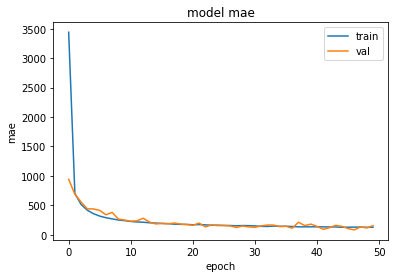

In [ ]:
#MAE plot
plt.plot(history_pow.history['mae'])
plt.plot(history_pow.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

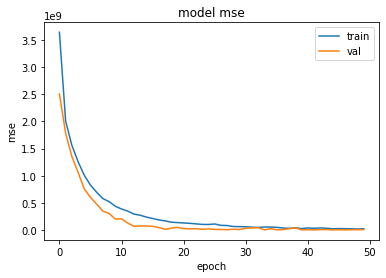

In [ ]:
#MSE plot
plt.plot(history_pow.history['mse'])
plt.plot(history_pow.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
y_pred = model.predict(X_test).reshape(1,-1)[0]
df_pred = X_test.copy()
df_pred['y_true'] = y_test
df_pred['y_pred'] = y_pred
df_pred

,wind_speed,wind_dir_cos,wind_dir_sin,air_den,y_true,y_pred
0,0.076600,0.154251,-0.988032,1.228,8059.224,8025.187012
1,0.046358,0.154251,-0.988032,1.215,1767.172,1780.303589
2,0.181015,-0.883877,0.467719,1.169,101209.792,100546.132812
3,0.000000,-0.445155,0.895454,1.219,0.000,0.000000
4,0.046358,-0.991199,-0.132382,1.174,1708.086,1724.978882
...,...,...,...,...,...,...
42371,0.000000,-0.445155,0.895454,1.284,0.000,0.000000
42372,0.046358,-0.991199,-0.132382,1.195,1737.751,1755.109131
42373,0.158940,-0.525348,0.850888,1.152,67500.650,67851.343750
42374,0.076600,-0.445155,0.895454,1.226,8045.275,8052.337402


In [ ]:
df_pred.to_csv('wind_pred.csv')

**Code for time series analysis of power consumption starts from here.**

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split

In [4]:
#The data
df = pd.read_csv('consumption_data2.csv', header=0)
df.head()

,READING_DATETIME,GENERAL_SUPPLY_KWH
0,2011-10-06,0.000
1,2011-10-07,0.000
2,2011-10-08,0.000
3,2011-10-09,0.000
4,2011-10-10,90.413


In [5]:
#Ensuring the days are continous in the dataset provided, without any date missing in between
diff_days_td = pd.to_datetime(df['READING_DATETIME'].shift(-1), format="%Y-%m-%d")-pd.to_datetime(df['READING_DATETIME'], format="%Y-%m-%d")
diff_days = diff_days_td.map(lambda x: x.days)
one_or_many_days = diff_days.value_counts().keys()
if(len(one_or_many_days)==1):
  print("No need to worry, not a single day missing in between")
else:
  print("Something's wrong!")

No need to worry, not a single day missing in between


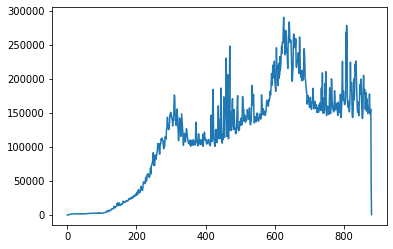

In [6]:
#Just plotting to get a broad view of the trend of the time series data, you can see the general trend is increasing almost monotonically
plt.plot(df.iloc[:,1])

In [7]:
#Since the trend is almost monotonically increasing as observed from the graph in previous cell, the last value can be assumed as some sort of outlier 
#graph at the end). Therefore, the last value along with first 3 values with zero general_power_supply is removed to make sure all general_power_supply values are non-zeroes 
df = df.iloc[4:-2,:].copy()

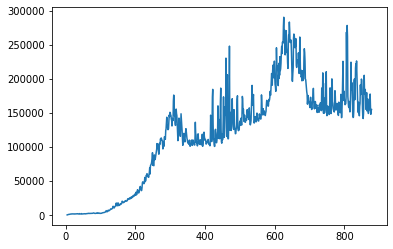

In [8]:
#Plot after removing outliers and zero valued general_power_supply
plt.plot(df.iloc[:,1])

In [9]:
from xgboost import XGBRegressor
from matplotlib import pyplot

#Converts time series data to supervised data format, with 10 prior timesteps as input, and output is just of one time step.
#In other words, we predict the next immediate value with the help of 10 prior values, and we prepare data in terms  of that.
def to_supervised_dataformat(data,n_out):
  dataset = []
  for i in range(data.shape[0]):
    if(i+10>data.shape[0]-1):
      break
    dataset.append(data[i:i+11])
  return(np.array(dataset))

def split_dataset_train_test(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
def refit_xgboost(train, test_instance):
	train = np.array(train)
	X_train, y_train = train[:, :-1], train[:, -1]

	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(X_train, y_train)

	y_pred = model.predict(np.asarray([test_instance]))
	return y_pred[0]
 
def walkforward_validation(data, n_test):
	predictions = list()
 	
	#Split the dataset into train and test
	train, test = split_dataset_train_test(data, n_test)
	
	#Contains the training dataset in list format which gets updated for every iteration as shown in the following for loop
	history = train.tolist()

	for i in range(len(test)):

		test_instance, test_instance_value = test[i, :-1], test[i, -1]
		
		#Refit Xgboost based on the updated training dataset and predict the testing instance
		pred = refit_xgboost(history, test_instance)
		predictions.append(pred)

		#Update the training dataset by appending test[i] to it.
		history.append(test[i])

	error = np.average(np.abs(test[:, -1]-predictions)/test[:,-1])
	return error, test[:, -1], predictions

data = to_supervised_dataformat(np.array(df.iloc[:,1]), n_out=10)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


MAPE: 0.074360


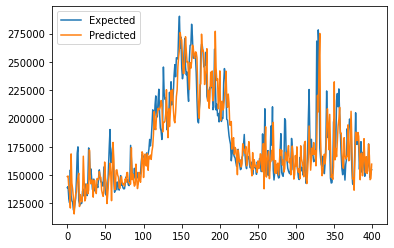

In [ ]:
#First Scenario

#Training Initially with 465 (865-400) data instances
mape, y, y_pred = walkforward_validation(data, 400)
print('MAPE: %f' % (mape))

pyplot.plot(y, label='Expected')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


MAPE: 0.077


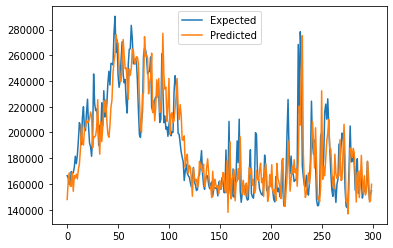

In [ ]:
#Second Scenario

#Training Initially with 565 (865-300) data instances
mape, y, y_pred = walkforward_validation(data, 300)
print('MAPE: %f' % mape)

pyplot.plot(y, label='Expected')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


MAPE: 0.078


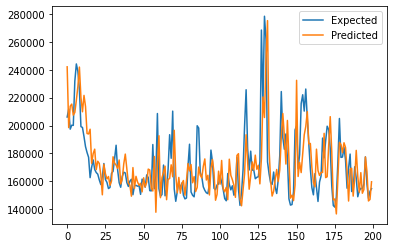

In [ ]:
#Third Scenario

#Training Initially with 665 (865-200) data instances
mape, y, y_pred = walkforward_validation(data, 200)
print('MAPE: %f' % mape)

pyplot.plot(y, label='Expected')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [10]:
#Running the first scenario training again, for getting predicted output.
mape, y, y_pred = walkforward_validation(data, 400)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


In [11]:
df_pred = pd.DataFrame()
df_pred['general_power_supply'] = y
df_pred['pred_general_power_supply'] = y_pred

In [ ]:
df_pred.to_csv('timeseries.csv')

In [12]:
df_pred.head()

,general_power_supply,pred_general_power_supply
0,138945.494,148804.562500
1,139896.392,149277.421875
2,129505.406,139091.578125
3,125581.330,134183.875000
4,154634.271,121015.125000


In [17]:
#Storing the model that has been trained on the entire dataset.
import pickle as pkl

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
X_train = data[:,:-1]
y_train = data[:,-1]
model.fit(X_train, y_train)

pkl.dump(model, open('consumption_data(Xgboostmodel).pkl','wb'))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
